In [1]:
# Might need to pip install json, json_stream, as they are not default libraries
import json
import json_stream
import numpy as np
import os
import yaml
import math

from MODSIM import perform_one_time_step_poseData, create_and_place_simple_legacy_camera, calculate_start_state
from datatypes.vessel import Vessel
from dynamicSceneGenerator import DynamicSceneGenerator
from errorGenerator import ErrorGenerator
from datatypes.cameraRig import CameraRig
from datatypes.virtualCamera import VirtualCamera
from datatypes.conditionState import ConditionState
from visualize import *


# Initialize MODSIM

In [2]:
vehicle_characteristics_path = 'boats_in_fishtank/vehicle_characteristics.json'
dynamics_path = 'boats_in_fishtank/dynamics.json'
simulation_folder = './simulations_for_report/simulation_3_less_error_vessel1/'

In [3]:
ERROR_CONFIG_PATH = 'detector_stats_config2.yaml'
WRITE_TO_JSON = True
VISUALIZE=True
CALCULATE = True
MIN_VESSELS = 1
MAX_TIME_STEPS = 5000
FPS = 10

In [4]:
# Camera types: 'STATIC_LEGACY', 'DYNAMIC'
STATIC_LEGACY = 'STATIC_LEGACY'
DYNAMIC = 'DYNAMIC'
DYNAMIC_CORAL_CAMERA = 'DYNAMIC_CORAL_CAMERA'
DNV_CAM = 'DNV_CAM'
ZED = 'ZED'
MID = 'MID'
LEFT = 'LEFT'
RIGHT = 'RIGHT'

CAMERA_TYPES = [DNV_CAM, DNV_CAM]
CAMERA_PLACEMENTS = [LEFT, RIGHT]

# Roll, yaw, pitch
ORIENTATION = [[0, np.pi/8, np.pi/200], [0, -np.pi/8, np.pi/200]]

In [5]:
NO_DISTURBANCE  = 0
SMALL_DISTURBANCE  = 1
MEDIUM_DISTURBANCE  = 2
LARGE_DISTURBANCE  = 4
HUGE_DISTURBANCE  = 6


wave_induced_camera_disturbance_coef = LARGE_DISTURBANCE  # int from 0-4

In [6]:
VESSEL_TO_PLACE_CAMERA_ON=1

### Temporal model

In [7]:
with open('detector_stats_config.yaml', 'r') as stream:
    config = yaml.safe_load(stream)

# Extract the parameters
initial_state = config['initial_state']
number_of_states = config['number_of_states']
transition_matrix = config['transitionMatrix']
labels = config['labels']
background_label = config['background_label']
confidence_threshold = config['confidenceThreshold']

states = {}

for stateID, state in config['states'].items():
    state_name = state['name']
    bb_error_stats = state['bb_error_stats']
    confusion_matrix = state['confusion_matrix']
    fdr = state['FDR']

    states[stateID] = ConditionState(state_name, stateID, confusion_matrix, bb_error_stats, fdr)

### Error generator

In [8]:
## Error generator
errorGenerator = ErrorGenerator(labels, background_label, confidence_threshold, transition_matrix, states, initial_state)

### DSG

In [9]:
# Get vessels
with open(vehicle_characteristics_path, 'r') as f:
    vessel_dict = json.load(f)

# air_draft: int = 2, beam: int = 2, length: int = 4, label: str = "")
vessels = [Vessel(vesselID, length=vessel['length_m'], beam=vessel['width_m'], label=vessel['type']) for vesselID, vessel in vessel_dict.items()]

In [10]:
# Create dynamic scene with vessels
dsg = DynamicSceneGenerator(vessels)

In [11]:
vessel_dict = {vessel.id: vessel for vessel in dsg.get_vessels()}

### Camera

In [12]:
def get_pos_vcf(vessel, placement):
    if placement == LEFT:
        return np.array([vessel.get_length()/2, vessel.get_beam()/2, vessel.get_air_draft()/2])
    elif placement == RIGHT:
        return np.array([vessel.get_length()/2, -vessel.get_beam()/2, vessel.get_air_draft()/2])
    else:
        # Default MID
        return np.array([vessel.get_length()/2, 0, vessel.get_air_draft()/2])


In [13]:
cameras = {}
for cameraID, cameraType in enumerate(CAMERA_TYPES):
    if cameraType == STATIC_LEGACY:
        VESSEL_TO_PLACE_CAMERA_ON = None
        ##### Static Camera #####
        # Create simple legacy camera and place it in the dynamic scene
        camera = create_and_place_simple_legacy_camera(dsg.get_larges_radius(), dsg.get_path_centre())

        ########################### OBS  ###################################################### 
        # If there is a static camera, there can only be one camera in the camera rig
        ####################################################################################### 
        cameras = {}
        cameras[0] = camera
        vessel = None
        break

    elif cameraType == DYNAMIC:
        ###### Dynamic Camera ######
        focal_length = 50*10**-3
        image_bounds = (3600, 2400) # Pixels (x,y)
        film_size = (36*10**-3, 24*10**-3)
        px = film_size[0]/image_bounds[0]
        py = film_size[1]/image_bounds[1]
        principal_point = (image_bounds[0]/2,image_bounds[1]/2)
        width_of_sensor = 36*10**-3 # Width of sensor

        # Pose
        roll_vcf = ORIENTATION[cameraID][0]
        yaw_vcf = ORIENTATION[cameraID][1]
        pitch_vcf = ORIENTATION[cameraID][2]
        vessel = vessels[VESSEL_TO_PLACE_CAMERA_ON] # Must be the same for al cameras in the camera rig
        pos_vcf = get_pos_vcf(vessel, CAMERA_PLACEMENTS[cameraID])

        camera = VirtualCamera(focal_length, px, py, principal_point, image_bounds)
        camera.place_camera_on_vessel(pos_vcf, roll_vcf, pitch_vcf, yaw_vcf)
    elif cameraType == DYNAMIC_CORAL_CAMERA:
        # https://www.tme.eu/Document/3e25990c825098a96a442d65b17c6632/CORAL-CAMERA-5MP.pdf
        ###### Dynamic Camera ######
        # Intrinsics
        # NB! Make sure everything is in meters
        focal_length = 2.5*10**-3
        image_bounds = (2592, 1933) # Pixels (x,y)
        #film_size = (1.4*10**-3, 1.4*10**-3)
        px = 1.4*10**-6
        py = 1.4*10**-6
        #px = 2*10**-6
        #py = 2*10**-6
        principal_point = (image_bounds[0]/2,image_bounds[1]/2)
        width_of_sensor = 36*10**-3 # Width of sensor

        # Pose
        roll_vcf = ORIENTATION[cameraID][0]
        yaw_vcf = ORIENTATION[cameraID][1]
        pitch_vcf = ORIENTATION[cameraID][2]
        vessel = vessels[VESSEL_TO_PLACE_CAMERA_ON]
        pos_vcf = get_pos_vcf(vessel, CAMERA_PLACEMENTS[cameraID])

        camera = VirtualCamera(focal_length, px, py, principal_point, image_bounds)
        camera.place_camera_on_vessel(pos_vcf, roll_vcf, pitch_vcf, yaw_vcf)
    elif cameraType == ZED:
        # Intrinsics
        # NB! Make sure everything is in meters
        focal_length = 2.8*10**-3
        image_bounds = (2688, 1520) # Pixels (x,y)
        #film_size = (1.4*10**-3, 1.4*10**-3)
        fx = 1404.2700
        fy = 1404.8199
        px = focal_length/fx
        py = focal_length/fy
        #px = 2*10**-6
        #py = 2*10**-6
        principal_point = (1110.9700,614.7650)

        # Pose
        roll_vcf = ORIENTATION[cameraID][0]
        yaw_vcf = ORIENTATION[cameraID][1]
        pitch_vcf = ORIENTATION[cameraID][2]
        vessel = vessels[VESSEL_TO_PLACE_CAMERA_ON]
        pos_vcf = get_pos_vcf(vessel, CAMERA_PLACEMENTS[cameraID])


        camera = VirtualCamera(focal_length, px, py, principal_point, image_bounds)
        camera.place_camera_on_vessel(pos_vcf, roll_vcf, pitch_vcf, yaw_vcf)
    elif cameraType == DNV_CAM:
        width = 2464
        height = 2056
        h_fov = 55 # degrees

        # NB! Make sure everything is in meters
        image_bounds = (2464, 2056) # Pixels (x,y)

        p = height / width
        focal_length = (float(width) * 0.5) / math.tan(
            math.radians(h_fov * 0.5))*10**-6  # Calculating the focal length from the FoV
        cam = np.eye(3, dtype=np.float32)
        cx = width * 0.5  # define center x
        cy = height * 0.5  # define center y
        fx = focal_length # define focal length x
        fy = focal_length * p  # (vFov / fov)  # define focal length y scaled to vertical fov
        px = 1*10**-6
        py = p*10**-6

        principal_point = (cx,cy)

        # Pose
        roll_vcf = ORIENTATION[cameraID][0]
        yaw_vcf = ORIENTATION[cameraID][1]
        pitch_vcf = ORIENTATION[cameraID][2]
        vessel = vessels[VESSEL_TO_PLACE_CAMERA_ON]
        pos_vcf = get_pos_vcf(vessel, CAMERA_PLACEMENTS[cameraID])


        camera = VirtualCamera(focal_length, px, py, principal_point, image_bounds)
        camera.place_camera_on_vessel(pos_vcf, roll_vcf, pitch_vcf, yaw_vcf)
    # elif cameraType == OTHER TYPES:
    
    cameras[cameraID] = camera

camera_rig = CameraRig(cameras, vessel, wave_induced_camera_disturbance_coef=wave_induced_camera_disturbance_coef)


# Stream pose data

In [14]:
# Opening JSON file: containing the poses of the moving obstacles - the important stuff
f = open(dynamics_path)
# Returns JSON object as a dictionary stream
data_dynamic = json_stream.load(f, persistent=True)

In [15]:
# Start streaming
time_stream = data_dynamic["time_s"]
for i, t in enumerate(time_stream):
    if float(t) > MAX_TIME_STEPS:
        break
    # One timestep at the time
    for vesselID in time_stream[t].keys():
        # Get current pose data: all given in world coordinates btw.
        center_pos = time_stream[t][vesselID]["center_position_m"]
        heading = time_stream[t][vesselID]["heading_rad"]
        x = center_pos[0]
        y = center_pos[1]
        z = 0
        time_stamp = float(t)
        vessel_dict[vesselID].get_track().addPosition(x, y, z, heading, time_stamp)
    if CALCULATE:    
        perform_one_time_step_poseData(dsg, errorGenerator, camera_rig, time_stamp, writeToJson=WRITE_TO_JSON, path=simulation_folder)


Horizon points are equal, find a new one [1218.06897403  881.25248472], [1218.44661231  881.21078912]
Horizon points are equal, find a new one [1218.06897403  881.25248472], [1218.39232605  881.21678294]
Horizon points are equal, find a new one [1218.06897403  881.25248472], [1218.39710832  881.21625492]
Horizon points are equal, find a new one [1218.06897403  881.25248472], [1218.39280646  881.2167299 ]
Horizon points are equal, find a new one [1218.06897403  881.25248472], [1218.40508404  881.21537431]
Horizon points are equal, find a new one [1230.09518347  999.55799227], [1229.66990041  999.5889532 ]
Horizon points are equal, find a new one [1230.09518347  999.55799227], [1230.02916131  999.56279873]
Horizon points are equal, find a new one [1230.09518347  999.55799227], [1230.03082841  999.56267737]
Horizon points are equal, find a new one [1230.09518347  999.55799227], [1230.03118669  999.56265128]
Horizon points are equal, find a new one [1230.09518347  999.55799227], [1230.0316

Moviepy - Building video ./simulations_for_report/simulation_3/camera_position.mp4.
Moviepy - Writing video ./simulations_for_report/simulation_3/camera_position.mp4



Moviepy - Done !
Moviepy - video ready ./simulations_for_report/simulation_3/camera_position.mp4
Loading projections from json
Visualizing projections
Moviepy - Building video ./simulations_for_report/simulation_3/projectedPoints_C0.mp4.
Moviepy - Writing video ./simulations_for_report/simulation_3/projectedPoints_C0.mp4



Moviepy - Done !
Moviepy - video ready ./simulations_for_report/simulation_3/projectedPoints_C0.mp4
Loading projections from json
Visualizing projections
Moviepy - Building video ./simulations_for_report/simulation_3/projectedPoints_C1.mp4.
Moviepy - Writing video ./simulations_for_report/simulation_3/projectedPoints_C1.mp4



Moviepy - Done !
Moviepy - video ready ./simulations_for_report/simulation_3/projectedPoints_C1.mp4
Moviepy - Building video ./simulations_for_report/simulation_3/projectedPoints.mp4.
Moviepy - Writing video ./simulations_for_report/simulation_3/projectedPoints.mp4



Moviepy - Done !
Moviepy - video ready ./simulations_for_report/simulation_3/projectedPoints.mp4
Moviepy - Building video ./simulations_for_report/simulation_3/detections_C0.mp4.
Moviepy - Writing video ./simulations_for_report/simulation_3/detections_C0.mp4



Moviepy - Done !
Moviepy - video ready ./simulations_for_report/simulation_3/detections_C0.mp4
Moviepy - Building video ./simulations_for_report/simulation_3/detections_C1.mp4.
Moviepy - Writing video ./simulations_for_report/simulation_3/detections_C1.mp4



Moviepy - Done !
Moviepy - video ready ./simulations_for_report/simulation_3/detections_C1.mp4
Moviepy - Building video ./simulations_for_report/simulation_3/detections.mp4.
Moviepy - Writing video ./simulations_for_report/simulation_3/detections.mp4



Moviepy - Done !
Moviepy - video ready ./simulations_for_report/simulation_3/detections.mp4


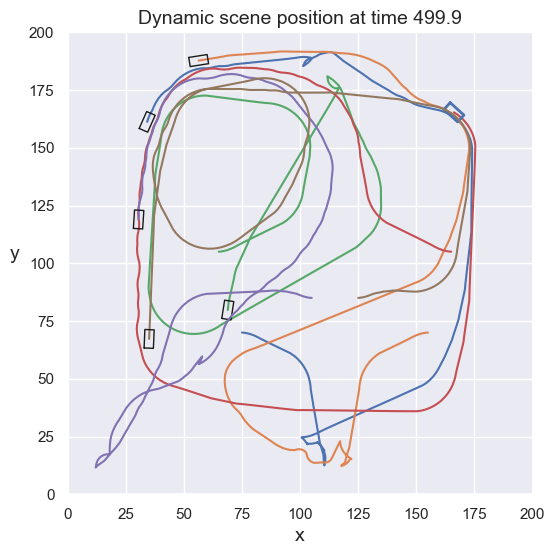

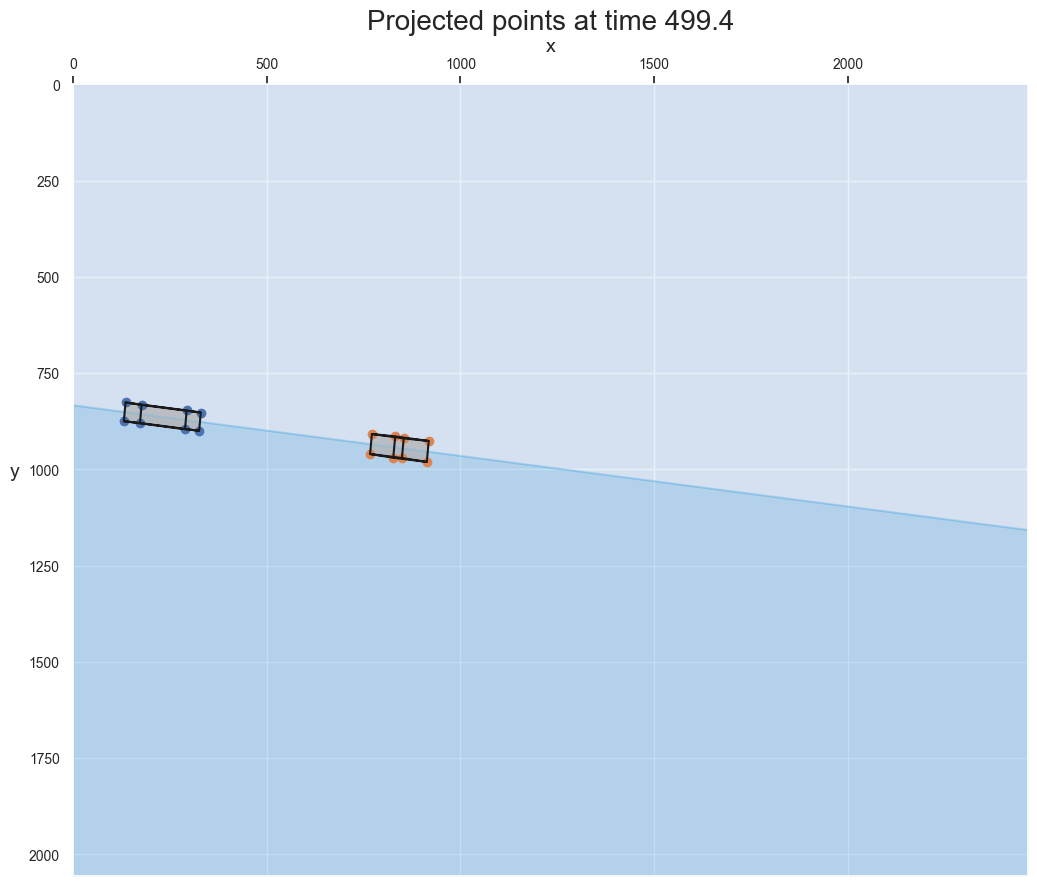

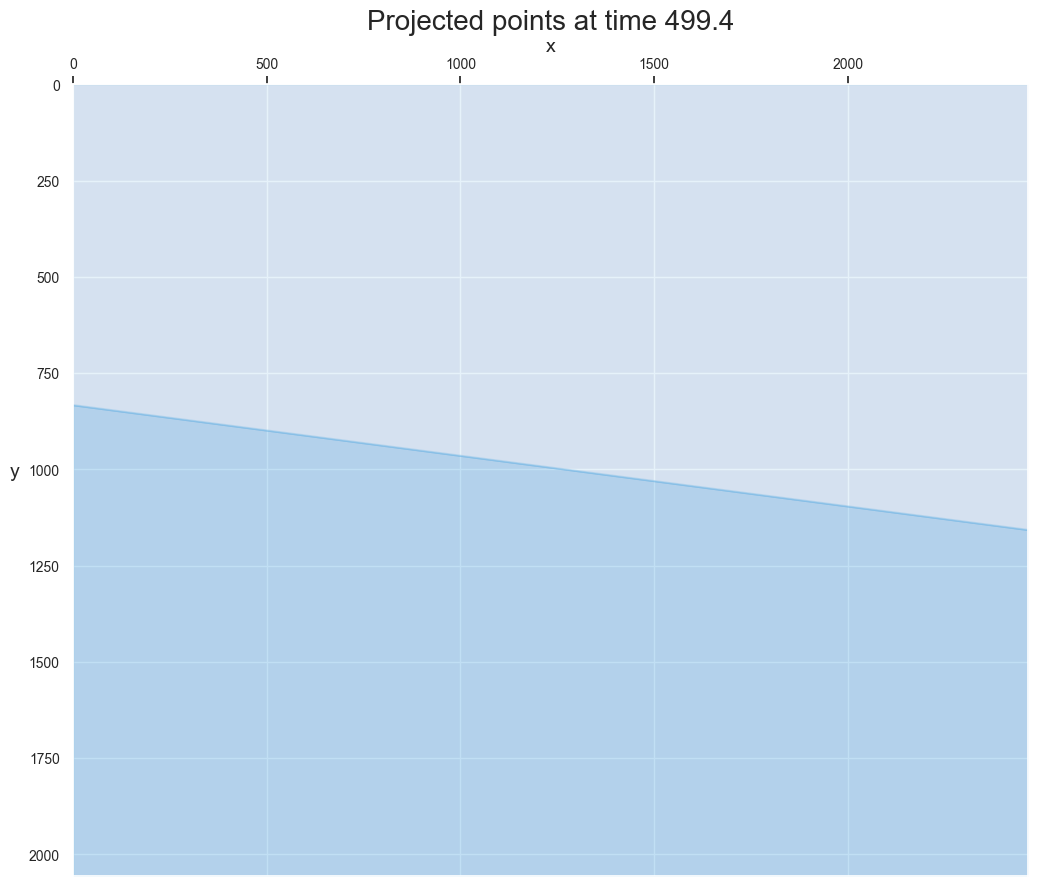

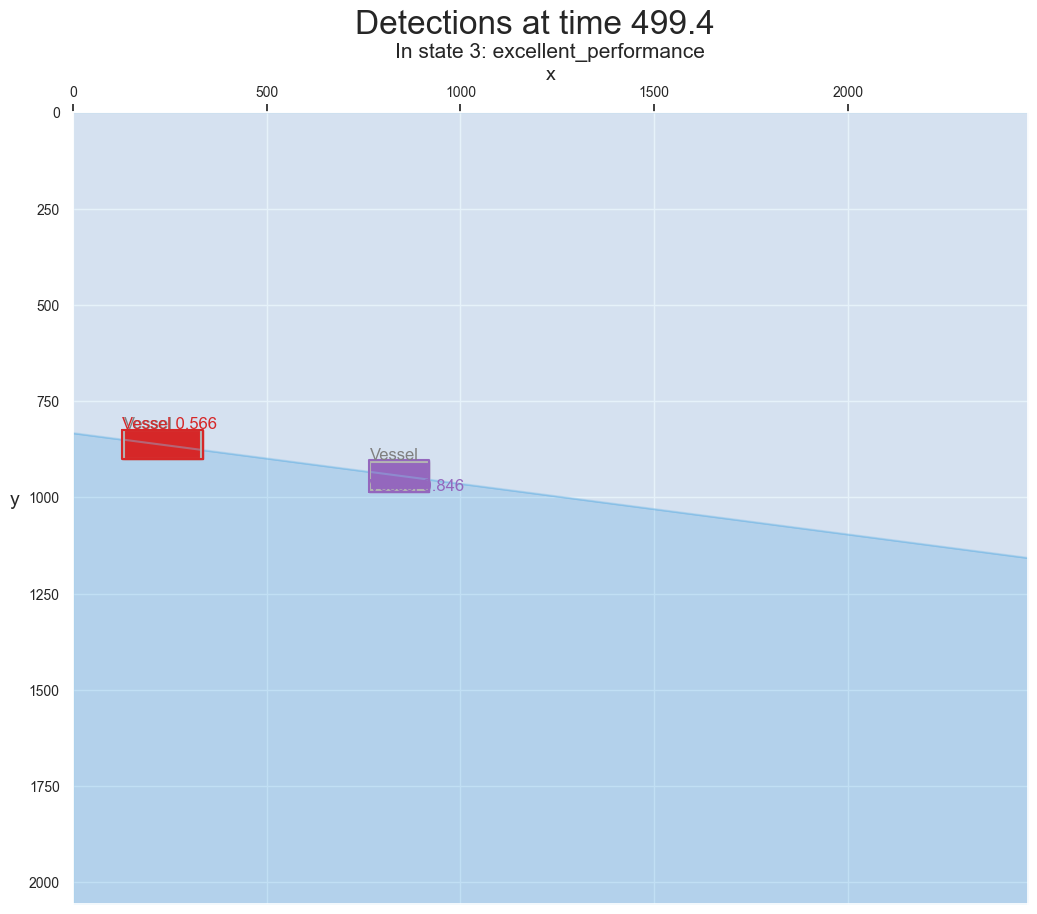

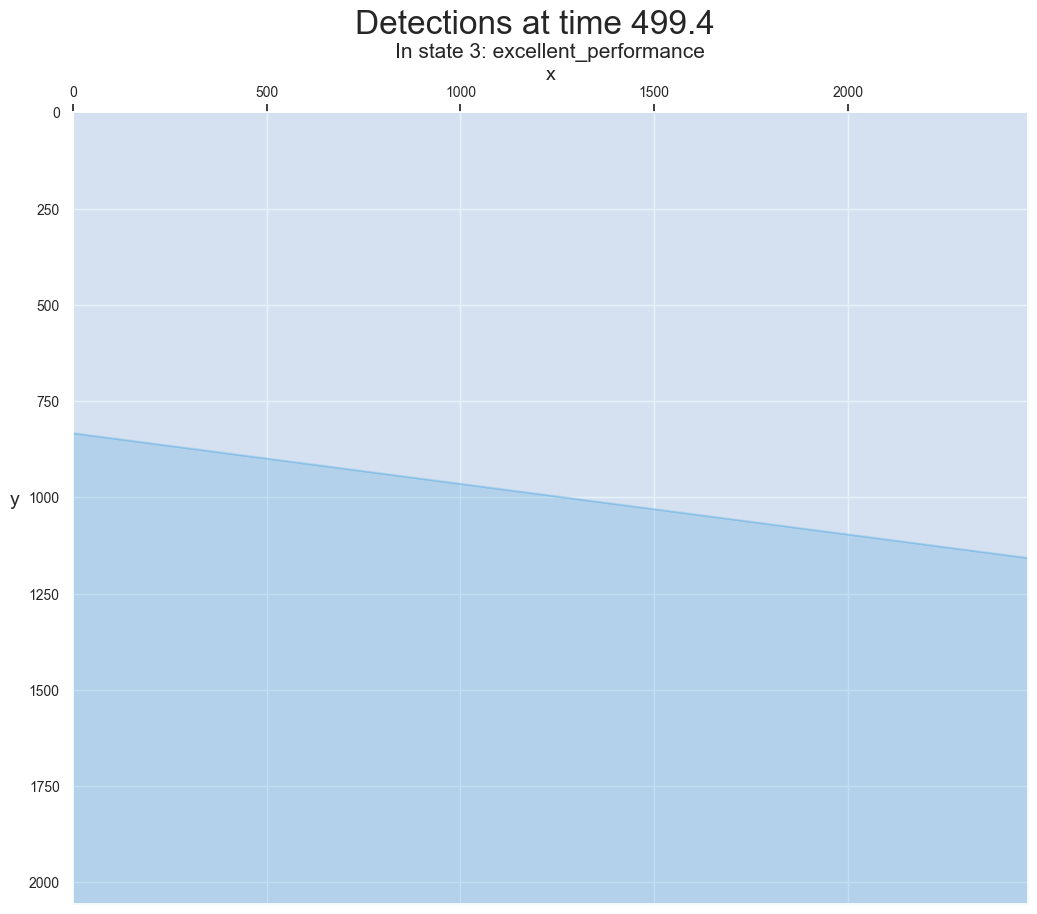

In [16]:
# Visualize from json files
if VISUALIZE:
    #pps_path = os.path.join(simulation_folder, 'projectedPoints.json')
    #annot_path = os.path.join(simulation_folder, 'annotations.json')
    #detection_path = os.path.join(simulation_folder, 'detections.json')

    pps_paths = {cameraID: os.path.join(simulation_folder, f'projectedPoints_C{cameraID}.json') for cameraID in cameras.keys()}
    annots_paths = {cameraID: os.path.join(simulation_folder, f'annotations_C{cameraID}.json') for cameraID in cameras.keys()}
    detections_paths = {cameraID: os.path.join(simulation_folder, f'detections_C{cameraID}.json') for cameraID in cameras.keys()}
    image_bounds = {cameraID: camera_rig.cameras[cameraID].image_bounds for cameraID in cameras.keys()}
    cameraIDs = list(cameras.keys())
    ownship_id = vessels[VESSEL_TO_PLACE_CAMERA_ON].id if VESSEL_TO_PLACE_CAMERA_ON else None
    

    #visualize_dynamic_scene_mov(vessels, folder_path=simulation_folder, fps=FPS, max_time_steps=MAX_TIME_STEPS, y_x_lim=200)
    visualize_camera_pose_in_dsg_mov(camera_rig, vessels, folder_path=simulation_folder, fps=FPS, max_time_steps=MAX_TIME_STEPS, y_x_lim=200, ownship_id=ownship_id)
    visualize_projections_multiple_cameras(cameraIDs, pps_paths, image_bounds, camera_rig.horizon, folder_path=simulation_folder,fps=FPS, max_time_steps=MAX_TIME_STEPS, display_when_min_vessels=MIN_VESSELS)
    #visualize_annotations_multiple_cameras(cameraIDs, annots_paths, image_bounds, horizons=camera_rig.horizon, folder_path=simulation_folder, fps=FPS, max_time_steps=MAX_TIME_STEPS, display_when_min_vessels=MIN_VESSELS)
    visualize_detections_multiple_cameras(cameraIDs, detections_paths, image_bounds, horizons=camera_rig.horizon, show_annotations=True, annotations_paths=annots_paths, folder_path=simulation_folder, fps=FPS, max_time_steps=MAX_TIME_STEPS, display_when_min_vessels=MIN_VESSELS, temporal_state_history=errorGenerator.temporal_model.previous_states, temporal_state_names=errorGenerator.temporal_model.state_names)
